# Compute dissociation curves for strong coupling systems with QunaSys QSCI


*Usage estimate (NOTE: This is an estimate only. Your runtime may vary.)*

* 5 minutes QPU time on ibm\_strasbourg
* 2.5 minutes QPU time on ibm\_torino


## Background

Finding the ground state energy of molecules is a common step in material science, drug discovery and various other fields. Solving the ground state energy for strong coupling system in the dissociation process is particularly known to be difficult with classical methods such as Hartree-Fock (HF), CISD and CCSD. While FCI produces the exact ground state of the given Hamiltonain, diagonalizing the Hamiltonian using the full subspace basis vectors and is usually computationally costly. In this tutorial, you will learn how to use QURI Chemistry to produce the dissociation curve of $N_2$.


## Requirements

Install the following dependencies to run the code in this tutorial.


In [ ]:
!pip install qiskit-ibm-catalog
!pip install pyscf

## Setup

To use QURI Chemistry, select the function via `QiskitFunctionCatalog`. You need an IBM Quantum Premium Plan account with a license from Qunasys to run this function.


In [ ]:
from qiskit_ibm_catalog import QiskitFunctionsCatalog

catalog = QiskitFunctionsCatalog()
qsci = catalog.load("qunasys/qsci")

## Step 1: Map classical inputs to a quantum problem

Construct the molecule in json format. As an illustration, we assume the separation between the 2 nitrogen atoms to be 1 angstrom apart from each other.


In [ ]:
parameters = {}

parameters["mole"] = {"atom": "N 0 0 0; N 0 0 1.0"}

Next, configure the QSCI algorithm by selecting the ansatz. Double excitation ansatz is recommended. CCSD parameter is used to prepare the ansatz.


In [ ]:
parameters["ansatz"] = "DoubleExcitation"
parameters["ansatz_setting"] = {"n_amplitudes": 20}
parameters["state_prep_method"] = "CCSD"

Discretion is required to select the subspace size $R$ to run the QSCI algorithm. A space too small cannot capture enough important configurations. However, a space too large would correspond to FCI and the use of quantum computers become redundant. In the sto-3g basis, $N_2$ contains 10 spatial orbitals and 14 electrons. This thus maps to a 20-qubit problem. The FCI space contains 14400 basis vectors, so the selected subspace size should not approach this value. We choose half of this size as the subspace size for demonstration.


In [ ]:
parameters["qsci_setting"] = {
    "n_shots": 100000,
    "number_of_states_pick_out": 7200
}

In [ ]:
from pprint import pprint
pprint(parameters)

{'ansatz': 'DoubleExcitation',
 'ansatz_setting': {'n_amplitudes': 20},
 'mole': {'atom': 'N 0 0 0; N 0 0 1.0'},
 'qsci_setting': {'n_shots': 100000, 'number_of_states_pick_out': 7200},
 'state_prep_method': 'CCSD'}


To improve the performance, it is recommended to turn on configuration recovery. For 20 qubit system with $R = 7200$, using the default confiugration recovery setting is sufficient.


In [ ]:
parameters["mitigation_setting"] = {"configuration_recovery": True}

## Step 3: Execute using Qiskit Primitives

Now, pick the backend to submit the job to the function


In [ ]:
result = qsci.run(
    method="QSCI",
    parameters=parameters,
    backend="ibm_torino",
)

In [ ]:
qsci_energy = result["qsci_energy"]
state_vector = result["state_vector"].copy()

FCI computation is still feasible at the scale of 20-qubit. We use PySCF to perform several classical computations and compare the energies against the QSCI energy.


## Step 4: Compare with classical methods


In [ ]:
from pyscf import gto, scf, cc, ci, fci

mole = gto.M(atom="N 0 0 0; N 0 0 1.0")
mf = scf.RHF(mole).run(verbose=0)
cisd = ci.CISD(mf).run(verbose=0)
ccsd = cc.CCSD(mf).run(verbose=0)
fci_solver = fci.FCI(mf).run()

print(f"HF energy   : {mf.e_tot: .4f} Ha, error: {(mf.e_tot - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"CISD energy : {cisd.e_tot: .4f} Ha, error: {(cisd.e_tot - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"CCSD energy : {ccsd.e_tot: .4f} Ha, error: {(ccsd.e_tot - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"QSCI energy : {qsci_energy: .4f} Ha, error: {(qsci_energy - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"FCI energy  : {fci_solver.e_tot: .4f} Ha")

HF energy   : -107.4195 Ha, error:  129.77 mHa
CISD energy : -107.5414 Ha, error:  7.91 mHa
CCSD energy : -107.5467 Ha, error:  2.58 mHa
QSCI energy : -107.5492 Ha, error:  0.09 mHa
FCI energy  : -107.5493 Ha


You can see that QSCI is the only method that falls into the chemical accuracy region where energy error needs to be less than 1.6 mHa, and this is done by diagonalizing the subspace Hamiltonian *half* the size of the FCI space.


## Producing the dissociation curve

As mentioned at the beginning of this tutorial, the non-triviality of our method is that it produces the *whole* $N_2$ dissociation curve with high accuracy. You can reuse the qsci input above with different distance settings.


In [ ]:
def get_qsci_json(distance: float) -> None:
    return {
        'mole': {'atom': f'N 0 0 0; N 0 0 {distance}'},
        'ansatz': 'DoubleExcitation',
        'state_prep_method': 'CCSD',
        'ansatz_setting': {'n_amplitudes': 20},
        'qsci_setting': {
            'n_shots': 100000,
            'number_of_states_pick_out': 7200
        },
        'mitigation_setting': {
            'configuration_recovery': True
        }
    }

With this function, we scan over $d = 0.7, 1.0, 1.5, 2.0, 2.4$.


#### d = 0.7 angstrom


In [ ]:
input_07 = get_qsci_json(0.7)
result_07 = qsci.run(method="QSCI", parameters=input_07, backend="ibm_torino")

In [ ]:
mole = gto.M(atom="N 0 0 0; N 0 0 0.7")
mf = scf.RHF(mole).run(verbose=0)
cisd = ci.CISD(mf).run(verbose=0)
ccsd = cc.CCSD(mf).run(verbose=0)
fci_solver = fci.FCI(mf).run()

qsci_energy_07 = result_07["qsci_energy"]
print(f"HF energy   : {mf.e_tot: .4f} Ha, error: {(mf.e_tot - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"CISD energy : {cisd.e_tot: .4f} Ha, error: {(cisd.e_tot - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"CCSD energy : {ccsd.e_tot: .4f} Ha, error: {(ccsd.e_tot - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"QSCI energy : {qsci_energy_07: .4f} Ha, error: {(qsci_energy_07 - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"FCI energy  : {fci_solver.e_tot: .4f} Ha")

HF energy   : -105.6974 Ha, error:  67.57 mHa
CISD energy : -105.7632 Ha, error:  1.76 mHa
CCSD energy : -105.7642 Ha, error:  0.75 mHa
QSCI energy : -105.7650 Ha, error:  0.01 mHa
FCI energy  : -105.7650 Ha


#### d = 1.5 angstrom


In [ ]:
input_15 = get_qsci_json(1.5)
result_15 = qsci.run(method="QSCI", parameters=input_15, backend="ibm_torino")

In [ ]:
mole = gto.M(atom="N 0 0 0; N 0 0 1.5")
mf = scf.RHF(mole).run(verbose=0)
cisd = ci.CISD(mf).run(verbose=0)
ccsd = cc.CCSD(mf).run(verbose=0)
fci_solver = fci.FCI(mf).run()

qsci_energy_15 = result_15["qsci_energy"]
print(f"HF energy   : {mf.e_tot: .4f} Ha, error: {(mf.e_tot - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"CISD energy : {cisd.e_tot: .4f} Ha, error: {(cisd.e_tot - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"CCSD energy : {ccsd.e_tot: .4f} Ha, error: {(ccsd.e_tot - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"QSCI energy : {qsci_energy_15: .4f} Ha, error: {(qsci_energy_15 - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"FCI energy  : {fci_solver.e_tot: .4f} Ha")

HF energy   : -107.2724 Ha, error:  309.19 mHa
CISD energy : -107.5269 Ha, error:  54.69 mHa
CCSD energy : -107.5679 Ha, error:  13.78 mHa
QSCI energy : -107.5810 Ha, error:  0.66 mHa
FCI energy  : -107.5816 Ha


#### d = 2.0 angstrom


In [ ]:
input_20 = get_qsci_json(2.0)
result_20 = qsci.run(method="QSCI", parameters=input_20, backend="ibm_torino")

In [ ]:
mole = gto.M(atom="N 0 0 0; N 0 0 2.0")
mf = scf.RHF(mole).run(verbose=0)
cisd = ci.CISD(mf).run(verbose=0)
ccsd = cc.CCSD(mf).run(verbose=0)
fci_solver = fci.FCI(mf).run()

qsci_energy_20 = result_20["qsci_energy"]
print(f"HF energy   : {mf.e_tot: .4f} Ha, error: {(mf.e_tot - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"CISD energy : {cisd.e_tot: .4f} Ha, error: {(cisd.e_tot - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"CCSD energy : {ccsd.e_tot: .4f} Ha, error: {(ccsd.e_tot - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"QSCI energy : {qsci_energy_20: .4f} Ha, error: {(qsci_energy_20 - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"FCI energy  : {fci_solver.e_tot: .4f} Ha")

HF energy   : -106.8715 Ha, error:  583.65 mHa
CISD energy : -107.2857 Ha, error:  169.48 mHa
CCSD energy : -107.5570 Ha, error: -101.83 mHa
QSCI energy : -107.4519 Ha, error:  3.21 mHa
FCI energy  : -107.4552 Ha


#### d = 2.4 angstrom


In [ ]:
input_24 = get_qsci_json(2.4)
result_24 = qsci.run(method="QSCI", parameters=input_24, backend="ibm_torino")

In [ ]:
mole = gto.M(atom="N 0 0 0; N 0 0 2.4")
mf = scf.RHF(mole).run(verbose=0)
cisd = ci.CISD(mf).run(verbose=0)
ccsd = cc.CCSD(mf).run(verbose=0)
fci_solver = fci.FCI(mf).run()

qsci_energy_24 = result_24["qsci_energy"]
print(f"HF energy   : {mf.e_tot: .4f} Ha, error: {(mf.e_tot - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"CISD energy : {cisd.e_tot: .4f} Ha, error: {(cisd.e_tot - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"CCSD energy : {ccsd.e_tot: .4f} Ha, error: {(ccsd.e_tot - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"QSCI energy : {qsci_energy_24: .4f} Ha, error: {(qsci_energy_24 - fci_solver.e_tot) * 1000: .2f} mHa")
print(f"FCI energy  : {fci_solver.e_tot: .4f} Ha")

HF energy   : -106.6566 Ha, error:  784.70 mHa
CISD energy : -107.1734 Ha, error:  267.94 mHa
CCSD energy : -107.0828 Ha, error:  358.53 mHa
QSCI energy : -107.4413 Ha, error:  0.01 mHa
FCI energy  : -107.4413 Ha


### The dissociation curve

Finally, plot the QSCI energy against the classical methods: HF, CISD, CCSD, and FCI.
You can see that all the QSCI points match well with the FCI values.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

hf_list = []
cisd_list = []
ccsd_list = []
fci_list = []

for d in np.linspace(0.7, 2.4, 18):
    mole = gto.M(atom=f"N 0 0 0; N 0 0 {d}")
    mf = scf.RHF(mole).run(verbose=0)
    cisd = ci.CISD(mf).run(verbose=0)
    ccsd = cc.CCSD(mf).run(verbose=0)
    fci_solver = fci.FCI(mf).run()

    hf_list.append(mf.e_tot)
    cisd_list.append(cisd.e_tot)
    ccsd_list.append(ccsd.e_tot)
    fci_list.append(fci_solver.e_tot)

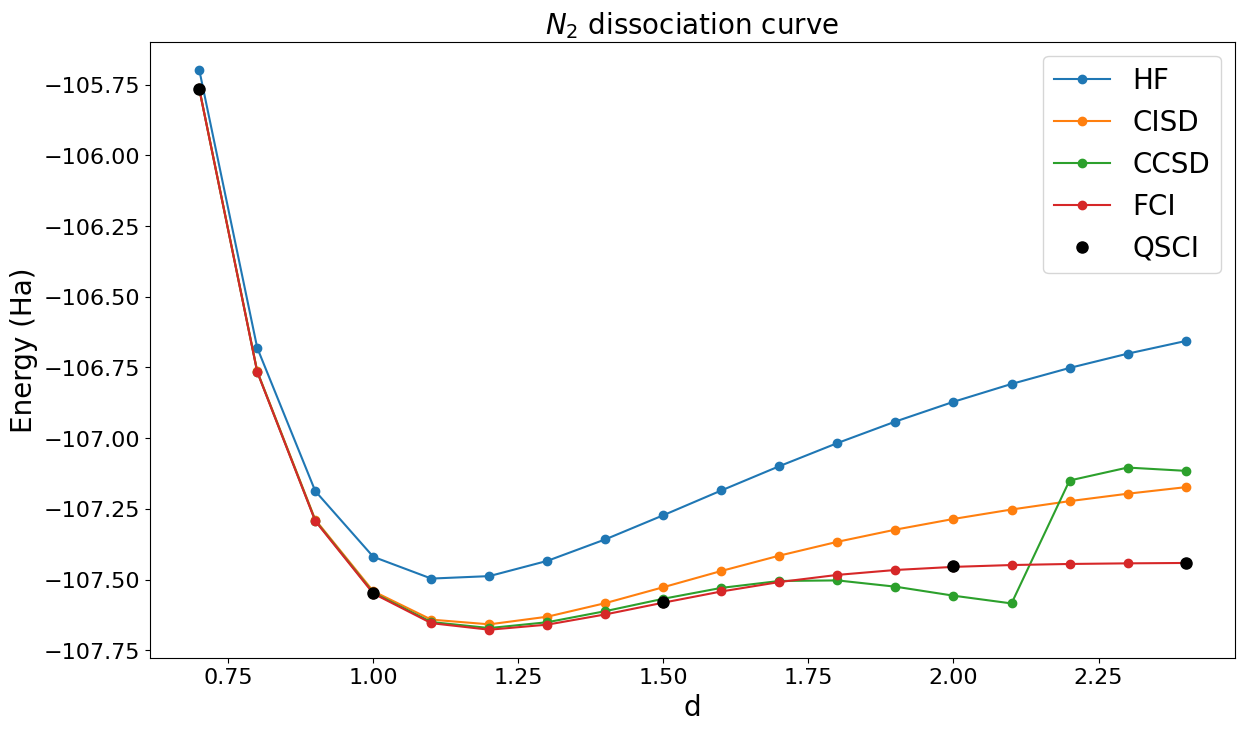

In [ ]:
ds = np.linspace(0.7, 2.4, 18)

fig, ax = plt.subplots(1, 1)
ax.plot(ds, hf_list, "-o", label="HF")
ax.plot(ds, cisd_list, "-o", label="CISD")
ax.plot(ds, ccsd_list, "-o", label="CCSD")
ax.plot(ds, fci_list, "-o", label="FCI")
ax.plot(
    [0.7, 1.0, 1.5, 2.0, 2.4],
    [qsci_energy_07, qsci_energy, qsci_energy_15, qsci_energy_20, qsci_energy_24],
    "o",
    color="black",
    markersize=8,
    label="QSCI"
)
ax.legend(fontsize=20)
ax.tick_params("both", labelsize=16)
ax.set_xlabel("d", size=20)
ax.set_ylabel("Energy (Ha)", size=20)
ax.set_title("$N_2$ dissociation curve", size=20)
fig.set_size_inches(14, 8)